In [2]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [3]:
from sklearn.decomposition import PCA 
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt 

from src.features import build_features

import logging 
from pathlib import Path

import scipy
import pickle
import datetime
import numpy as np

logging.basicConfig(level=logging.INFO)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\matan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\matan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\matan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Build Features
Use the build_features functions to build dataset from database (usually takes ~1 min)

In [4]:
load_fresh_features = False

proj_path = Path().resolve().parents[1]
processed_path = proj_path / "data" / "processed"

if load_fresh_features:
    today = str(datetime.date.today())
    features, pipe = build_features.bag_of_words_tfid_norm()
    scipy.sparse.save_npz(file=str(processed_path / f"features_{today}.npz"), matrix=features)
    pipe_path = str(processed_path / f"pipe_{today}.pkl")
    with open(pipe_path, 'wb') as file:
        pickle.dump(pipe, file)
    print(f"Date: {today}")
else:
    features, pipe = build_features.load_saved_features(date="2021-03-23")

INFO:src.features.build_features:Loading features and pipe from /data/processed/


# PCA
To visualize the clustering algorithms I'll use two or three principal components throughout this notebook.

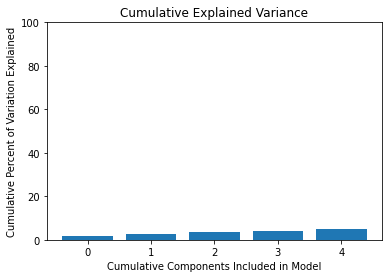

In [5]:
# initialize PCA:
# reduce features:
pca = PCA(n_components=5)
reduced_features = pca.fit_transform(features.toarray())

# display percent explained variance of the first ten components:
fig = plt.figure()
plt.bar(x=range(len(pca.explained_variance_ratio_)), height=np.cumsum(pca.explained_variance_ratio_)*100)
plt.ylim([0, 100])
plt.ylabel("Cumulative Percent of Variation Explained")
plt.xlabel("Cumulative Components Included in Model")
plt.title("Cumulative Explained Variance");

Unfortunately the first two components only seem to code for about 5% (if that) of the percent variation. This makes sense since the bog-of-words is massive, however this means that we cannot trust visual cluster, we'll need some empirical measure of clsuter goodness. 

In [6]:
import pandas as pd
pca.components_[0]

vocab = pipe.named_steps['tfidf_vec'][0].vocabulary_

loadings = pd.DataFrame(data=pca.components_, columns=vocab).T

topics = pd.DataFrame()

for t in loadings.columns:
    topics[str(t)] = loadings[t].sort_values(ascending=False)[:10].index.tolist()
    
topics

,0,1,2,3,4
0,newly,disruptionx,licensed,cut,legitimate
1,ba,coworking,mitigationoptimization,signa,mitigationoptimization
2,torch,is,highreaching,conception,chrl
3,uxrs,avanade,ubiquitous,legitimate,automated
4,comprendre,pst,http,expertise,pertinente
5,vicepresident,rule,talentneuron,wwwesolutionsinccom,applys
6,tourism,réussie,faster,downstream,forge
7,cost,personalized,damélioration,liberty,frameworks
8,public,perl,optimum,scikitlearn,bloor
9,consistently,ocr,fusion,conservation,productive


# SVD

In [15]:
from sklearn.decomposition import TruncatedSVD

svd_model = TruncatedSVD(n_components=10,         # num dimensions
                         algorithm='randomized',
                         n_iter=10)
svd_matrix = svd_model.fit_transform(features)

In [16]:
svd_matrix[0].shape

(10,)

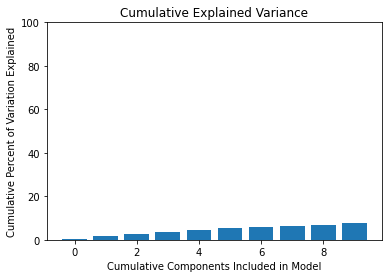

In [17]:
# display percent explained variance of the first ten components:
fig = plt.figure()
plt.bar(x=range(len(svd_model.explained_variance_ratio_)), height=np.cumsum(svd_model.explained_variance_ratio_)*100)
plt.ylim([0, 100])
plt.ylabel("Cumulative Percent of Variation Explained")
plt.xlabel("Cumulative Components Included in Model")
plt.title("Cumulative Explained Variance");

In [18]:
loadings = pd.DataFrame(data=svd_model.components_, columns=vocab).T

topics = pd.DataFrame()

for t in loadings.columns:
    topics[str(t)] = loadings[t].sort_values(ascending=False)[:10].index.tolist()
    
topics

,0,1,2,3,4,5,6,7,8,9
0,amaze,newly,disruptionx,licensed,legitimate,cut,possible,religious,possible,learningbased
1,newly,torch,coworking,mitigationoptimization,cut,conception,liberty,respectful,mitigationoptimization,possible
2,creation,ba,is,highreaching,chrl,signa,tenant,sujets,liberty,liberty
3,latency,uxrs,ocr,ubiquitous,mitigationoptimization,licensed,sunday,différence,rotational,licensed
4,sqlssis,vicepresident,nontraditional,http,pertinente,expertise,amaze,possible,sunday,completeness
5,souhaitezvous,cost,pst,talentneuron,automated,liberty,150m,outdoor,httpsrimuhccaen,recreation
6,crave,tourism,personalized,faster,signa,wwwesolutionsinccom,principally,offboarding,synthesis,children
7,children,comprendre,avanade,damélioration,forge,downstream,flow,student,hcmc,horowitz
8,increase,consistently,rule,optimum,applys,conservation,licensed,citymunicipality,comment,nonévidents
9,presentable,public,perl,nonunionunionjob,frameworks,scikitlearn,hcmc,optimise,na,municipal
